# Analysis of BMC solving with Z3

Pandas cheatsheet: https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf

There are 4 different encoding parameters:

  - **phi** whether the VC is encoded with phi-assignments. This is traditional encoding for `SeaHorn`
  - **gsa** whether the program is converted to Gated SSA before VCGen. In this case, there are no phi-assignments
  - **ite** whether phi-nodes are encoded with ite-expressions
  - **noite** whether phi-nodes are encoded with disjunction and equalities (traditional for `SeaHorn`)
  
Four combinations are considered: {ite, noite} x {phi, gsa}. 
The combination (ite, phi) is traditional for `SeaHorn`. The combination (ite, gsa) is meaningles since under gsa, there are no phi-nodes, and ite has no effect. Yet, the result show some difference between (ite, gsa) and (noite, gsa). This needs to be investigated further. Possibly the difference is due to usual SAT-solver non-determinism.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
df = pd.read_csv('bmc-z3.csv')
# move timeout and unknown to maximal time
df['time'].fillna(value=900, inplace=True)
# show a snapshot of data for visual validation
df.head()

,index,max_memory,memory,status,time
0,ldv-cat-0000.c.ite.gsa.smt2,0.09,0.09,unknown,900.00
1,ldv-cat-0000.c.ite.phi.smt2,0.09,0.09,unknown,900.00
2,ldv-cat-0000.c.noite.gsa.smt2,0.09,0.09,unknown,900.00
3,ldv-cat-0000.c.noite.phi.smt2,0.09,0.09,unknown,900.00
4,ldv-cat-0001.c.ite.gsa.smt2,3.31,3.01,unsat,0.01


In [3]:
# quick overview of solved/unsolved instances
df[['status','index']].groupby(['status']).count().reset_index()

,status,index
0,sat,101
1,timeout,88
2,unknown,24
3,unsat,181


In [4]:
# find all unknown results. Usually means that something went wrong, not just timeout
df[df.status == 'unknown']

,index,max_memory,memory,status,time
0,ldv-cat-0000.c.ite.gsa.smt2,0.09,0.09,unknown,900.0
1,ldv-cat-0000.c.ite.phi.smt2,0.09,0.09,unknown,900.0
2,ldv-cat-0000.c.noite.gsa.smt2,0.09,0.09,unknown,900.0
3,ldv-cat-0000.c.noite.phi.smt2,0.09,0.09,unknown,900.0
330,ldv-cat-0082.c.noite.gsa.smt2,0.09,0.09,unknown,900.0
332,ldv-cat-0083.c.ite.gsa.smt2,0.09,0.09,unknown,900.0
333,ldv-cat-0083.c.ite.phi.smt2,0.09,0.09,unknown,900.0
334,ldv-cat-0083.c.noite.gsa.smt2,0.09,0.09,unknown,900.0
335,ldv-cat-0083.c.noite.phi.smt2,0.09,0.09,unknown,900.0
336,ldv-cat-0084.c.ite.gsa.smt2,0.09,0.09,unknown,900.0


In [5]:
# split results into 4 groups
def flt_index(df, s):
    return df[df['index'].str.contains(s)]

noite_gsa = flt_index(df, r'\.noite.gsa')
ite_gsa = flt_index(df, r'\.ite.gsa')
ite_phi = flt_index(df, r'\.ite.phi')
noite_phi = flt_index(df, r'\.noite.phi')

## Solved / Unsolved for each group

In [6]:
noite_gsa.groupby('status').count().reset_index()

,status,index,max_memory,memory,time
0,sat,21,21,21,21
1,timeout,24,24,24,24
2,unknown,9,9,9,9
3,unsat,44,44,44,44


In [7]:
ite_gsa.groupby('status').count().reset_index()

,status,index,max_memory,memory,time
0,sat,22,22,22,22
1,timeout,23,23,23,23
2,unknown,7,7,7,7
3,unsat,46,46,46,46


In [8]:
ite_phi.groupby('status').count().reset_index()

,status,index,max_memory,memory,time
0,sat,26,26,26,26
1,timeout,23,23,23,23
2,unknown,4,4,4,4
3,unsat,46,46,46,46


In [9]:
noite_phi.groupby('status').count().reset_index()

,status,index,max_memory,memory,time
0,sat,32,32,32,32
1,timeout,18,18,18,18
2,unknown,4,4,4,4
3,unsat,45,45,45,45


In [10]:
# create a file column to join different result sets
def index_to_file(df):
    return df.assign(file=df['index'].str.extract(r'([^.]+)'), expand=False)
noite_phi = index_to_file(noite_phi)
ite_phi = index_to_file(ite_phi)
noite_gsa = index_to_file(noite_gsa)
ite_gsa = index_to_file(ite_gsa)

In [11]:
# join on file
phi = ite_phi.merge(noite_phi, on='file', suffixes=('_ite', '_noite'))

In [12]:
# solved / unsolved based on ite parameter
phi.groupby(['status_ite', 'status_noite']).count()[['file']].reset_index()

,status_ite,status_noite,file
0,sat,sat,26
1,timeout,sat,6
2,timeout,timeout,17
3,unknown,unknown,4
4,unsat,timeout,1
5,unsat,unsat,45


In [13]:
# merge gsa sets and show solved / unsolved
gsa = ite_gsa.merge(noite_gsa, on='file', suffixes=('_ite', '_noite'))
gsa.groupby(['status_ite', 'status_noite']).count()[['file']].reset_index()

,status_ite,status_noite,file
0,sat,sat,21
1,sat,timeout,1
2,timeout,timeout,22
3,timeout,unknown,1
4,unknown,unknown,7
5,unsat,timeout,1
6,unsat,unknown,1
7,unsat,unsat,44


<AxesSubplot:title={'center':'PHI'}, xlabel='time_ite', ylabel='time_noite'>

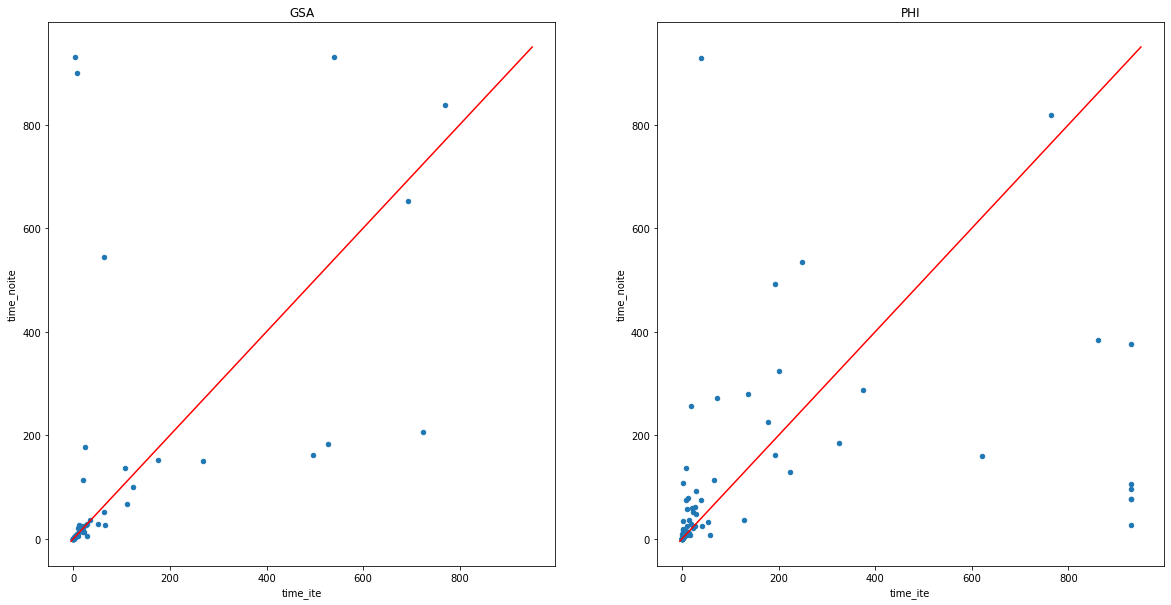

In [14]:
# set default figure size for plots to be 7 by 7 inches
plt.rcParams["figure.figsize"] = (7, 7)
# create a new figure 20 by 10 inches wide
fig = plt.figure(figsize=(20,10))
# break figure into two sub-plots
# ax1: the number '121' is parsed as plot 1 of 1x2 grid
ax1 = plt.subplot(121)
# ax2: the number '122' is parsed as plot 2 of 1x2 grid
ax2 = plt.subplot(122)
# plot a diagonal line to make scatter plots easier to read
x = np.linspace(-5, 950, 2)
ax1.plot(x, x, color='red')
ax2.plot(x, x, color='red')
# plot succeeded instances
gsa.query('status_ite=="sat" or status_ite=="unsat"').plot.scatter(x='time_ite', y='time_noite', ax=ax1, title='GSA')
phi.query('status_noite=="sat" or status_ite=="unsat"').plot.scatter(x='time_ite', y='time_noite', ax=ax2, title='PHI')

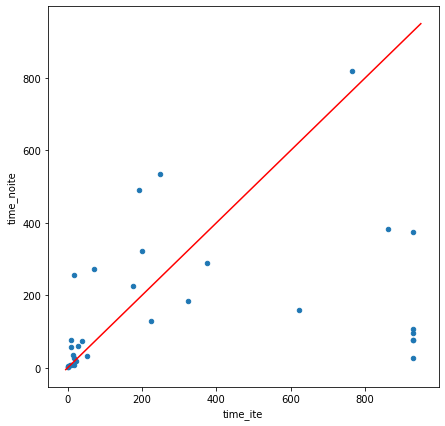

In [15]:
# a single plot is easier to create
ax = phi[phi.status_noite == 'sat'].plot.scatter(x='time_ite', y='time_noite')
ax.plot(x, x, color='red')

In [16]:
# summary of the plot. Useful to validate what is visible from the picture
phi.groupby(['status_ite', 'status_noite'])[['time_ite', 'time_noite']].describe()

time_ite                                            \
                           count        mean         std     min       25%   
status_ite status_noite                                                      
sat        sat              26.0  165.521538  243.004745    0.49   11.1475   
timeout    sat               6.0  929.858333    0.056716  929.79  929.8150   
           timeout          17.0  929.350588    0.394960  928.74  929.0100   
unknown    unknown           4.0  900.000000    0.000000  900.00  900.0000   
unsat      timeout           1.0   39.660000         NaN   39.66   39.6600   
           unsat            45.0   18.740000   39.602570    0.01    0.3000   

                                                   time_noite              \
                             50%       75%     max      count        mean   
status_ite status_noite                                                     
sat        sat            33.340  217.5600  860.47       26.0  172.484231   
timeout    sat           929.855  929.9025  929.93        6.0  126.326667   
           timeout       929.380  929.6900  929.87       17.0  929.262353   
unknown    unknown       900.000  900.0000  900.00        4.0  900.000000   
unsat      timeout        39.660   39.6600   39.66        1.0  928.090000   
           unsat           2.660   13.6400  191.31       45.0   31.583778   

                                                                          \
                                std     min       25%      50%       75%   
status_ite status_noite                                                    
sat        sat           204.876409    1.41   21.7625   74.865  267.9175   
timeout    sat           125.473912   26.06   76.5200   86.715  103.5475   
           timeout         0.479616  928.55  928.6900  929.260  929.6900   
unknown    unknown         0.000000  900.00  900.0000  900.000  900.0000   
unsat      timeout              NaN  928.09  928.0900  928.090  928.0900   
           unsat          54.687228    0.01    0.9300    8.360   33.9200   

                                 
                            max  
status_ite status_noite          
sat        sat           818.96  
timeout    sat           376.19  
           timeout       929.86  
unknown    unknown       900.00  
unsat      timeout       928.09  
           unsat         280.00

In [17]:
import sys
# install latest version of seaborn
!{sys.executable} -m pip install seaborn
# seaborn provides useful fancy plots
import seaborn as sns
sns.set(style='ticks', palette='Set2')

Defaulting to user installation because normal site-packages is not writeable


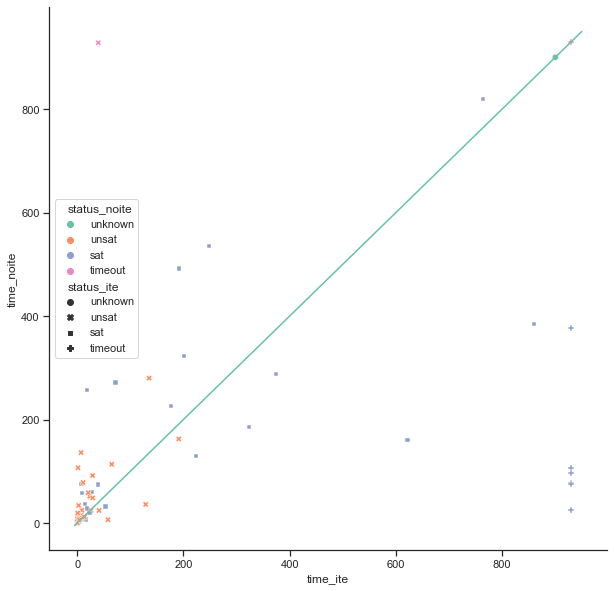

In [18]:
# use additional semantic features to separate sat/unsat instances
fig = plt.figure(figsize=(10,10))
g = sns.scatterplot(x="time_ite", y="time_noite", hue="status_noite", style='status_ite', data=phi);
sns.despine()
g.plot(x, x)

In [31]:
# !{sys.executable} -m pip install plotly nbformat
import plotly.express as px
# interactive graph for data exploration
fig = px.scatter(phi, x="time_ite", y="time_noite", color="status_noite", symbol="status_ite")
fig.update_layout(width=800, height=500, title='Time: ite vs noite')
fig.update_xaxes( range=[phi.time_ite.min() - 50, phi.time_ite.max() + 50],  constrain="domain")
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.show()